<a href="https://colab.research.google.com/github/BamdadBooyeh/BamdadBooyeh/blob/proj/NLP_MAIN_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing and loader





## Introduction


In this project, we apply core concepts from the course to a Natural Language Processing (NLP) task: emotion classification of English Twitter messages. We use the Emotion dataset from HuggingFace Datasets (dair-ai/emotion), which consists of short texts labeled with one of six emotion classes:

	•	0: sadness
	•	1: joy
	•	2: love
	•	3: anger
	•	4: fear
	•	5: surprise

The dataset comes with predefined train, validation, and test splits.

The goal is to build a pipeline that prepares this text data and train deep learning models to classify text emotion.

# Data Preprocessing and DataLoader Construction

1. **Dataset Loading**

The dataset splits (train, validation, test) were loaded from Hugging Face using the .parquet format and converted into pandas DataFrames for easier manipulation.

2. **Label Distribution Analysis**

We analyzed label counts in each split to assess class imbalance. The training set was heavily imbalanced, with class 1 (“joy”) dominating at ~34%, while class 5 (“surprise”) made up less than 5%. This information is crucial for interpreting model performance.

Split	Most Frequent Label	Accuracy if Always Predicts
Train	Joy (1)	34%
Chance (random)	-	17%

3. **Tokenization**

A basic whitespace tokenizer was implemented to lowercase and split the text into tokens. This approach was chosen for simplicity and transparency, giving us full control over vocabulary and encoding.

4. **Vocabulary Building**

We constructed a vocabulary from the training tokens, including special tokens <PAD> and <OOV>, resulting in 15,214 unique tokens. Words unseen in training default to <OOV> during encoding.

5. **Text Encoding & Padding**

Each sentence was encoded into integer token IDs using our vocabulary, and then padded to a fixed maximum length based on the 95th percentile of training sentence lengths (MAX_LEN = ~50). This ensures consistency across batches and improves training efficiency.

6. **Tensor Conversion and DataLoader Creation**

Finally, all processed inputs and labels were converted into PyTorch tensors and organized into TensorDataset objects. We wrapped them with DataLoaders using a batch size of 32, with shuffling applied only to the training set.




# Key Statistics and Insights

	•	Text Lengths: Mean length across splits was ~19 tokens with a wide spread, justifying our choice of max padding length.
	•	Class Distribution: Visual plots and counts exposed a high class imbalance, guiding our evaluation strategy.
	•	Vocabulary Size: A large vocabulary (15k+ tokens) suggests diverse language usage, which can help the model generalize well.

	•	Custom Control: Building our own tokenizer and vocabulary gave us insight and flexibility that libraries like Tokenizer or BERT would abstract away.
	•	Robustness: Handling edge cases (e.g., short texts, rare tokens) ensured that the model training step would not fail or skew.
	•	Baseline Understanding: Knowing the majority class accuracy (34%) provides a realistic baseline for evaluating our classifier.



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



[TRAIN] Label Counts:
         0: 4666
         1: 5362
         2: 1304
         3: 2159
         4: 1937
         5: 572

[VALIDATION] Label Counts:
         0: 550
         1: 704
         2: 178
         3: 275
         4: 212
         5: 81

[TEST] Label Counts:
         0: 581
         1: 695
         2: 159
         3: 275
         4: 224
         5: 66


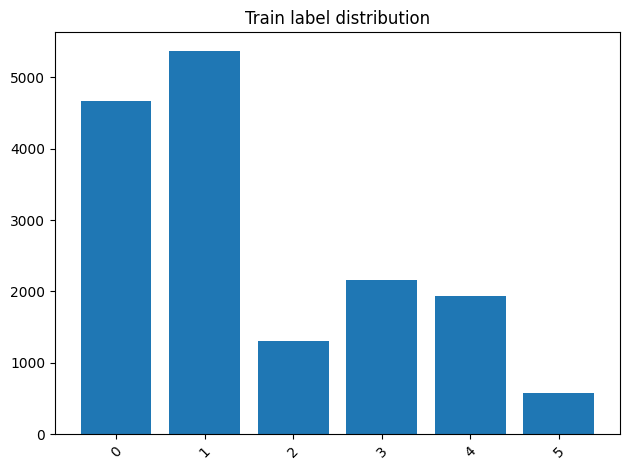

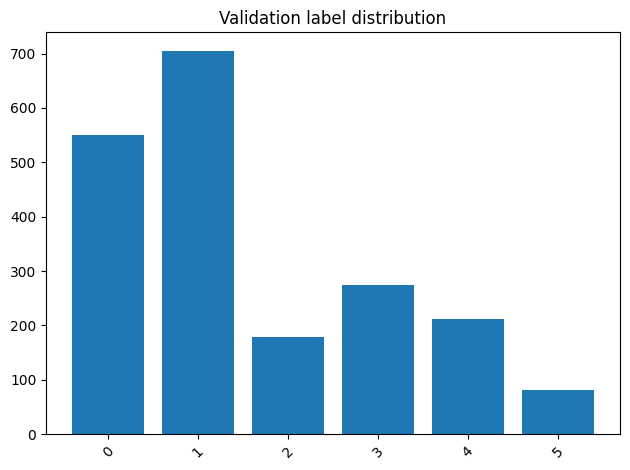

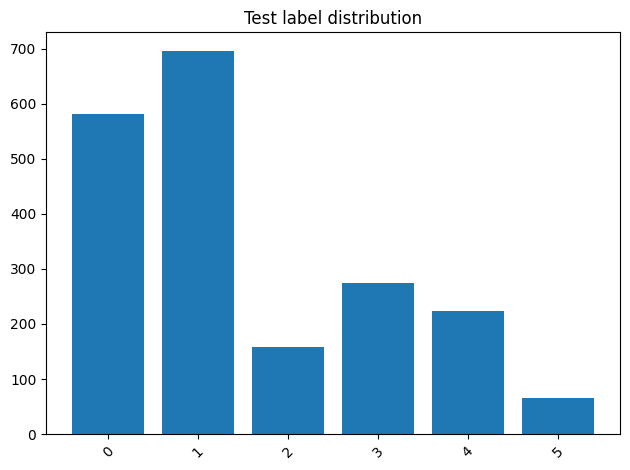


Chance accuracy: 0.17
Majority class baseline accuracy: 0.34 (1)

Train text length - Min: 2, Max: 66, Mean: 19.17, Std: 10.99

Validation text length - Min: 2, Max: 61, Mean: 18.87, Std: 10.81

Test text length - Min: 3, Max: 61, Mean: 19.15, Std: 11.01

Vocabulary size: 15214

 Data preparation complete. Loaders are ready!


In [1]:

import torch
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader # Import DataLoader and TensorDataset here

splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
dataset = {
    split: pd.read_parquet(f"hf://datasets/dair-ai/emotion/{path}")
    for split, path in splits.items()
}
label_names = sorted(dataset["train"]["label"].unique())
label_names = [str(lbl) for lbl in label_names]  # In case labels are ints

def label_stats(split):
    # Ensure dataset[split] is a DataFrame here
    if not isinstance(dataset[split], pd.DataFrame):
        print(f"Warning: dataset['{split}'] is not a DataFrame when calling label_stats.")
        # You might need to handle this case if label_stats is called after tensor conversion
        # For this fix, we assume label_stats is called before the conversion.
        return [], Counter() # Return empty results if not a DataFrame

    labels = dataset[split]["label"].tolist()
    counts = Counter(labels)
    print(f"\n[{split.upper()}] Label Counts:")
    for label, count in sorted(counts.items()):
        # Ensure label is within the bounds of label_names
        if label < len(label_names):
            print(f"{label_names[label]:>10}: {count}")
        else:
            print(f"Unknown label ({label}): {count}")
    return labels, counts

# Re-define splits as a list after the dictionary definition
splits = ['train', 'validation', 'test']
split_labels = {}
for split in splits:
    split_labels[split], counts = label_stats(split)

# Plot distribution
for split in splits:
    plt.figure()
    labels = split_labels[split]
    counts = Counter(labels)
    # Use label_names as x-axis labels and counts corresponding to label_names order
    plt.bar(label_names, [counts.get(i, 0) for i in range(len(label_names))]) # Use .get(i, 0) to handle potential missing labels
    plt.title(f"{split.capitalize()} label distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Chance accuracy (random guess)
total_train = len(split_labels['train'])
most_common_class = Counter(split_labels['train']).most_common(1)[0]
chance_accuracy = 1 / len(label_names)
majority_accuracy = most_common_class[1] / total_train
print(f"\nChance accuracy: {chance_accuracy:.2f}")
# Ensure index is within bounds
if most_common_class[0] < len(label_names):
    print(f"Majority class baseline accuracy: {majority_accuracy:.2f} ({label_names[most_common_class[0]]})")
else:
     print(f"Majority class baseline accuracy: {majority_accuracy:.2f} (Unknown label)")


# STEP 2: Tokenization
def tokenize(text):
    return text.lower().split()

# Apply tokenization while dataset is still a DataFrame
for split in splits:
    # Ensure dataset[split] is a DataFrame before applying .apply()
    if isinstance(dataset[split], pd.DataFrame):
        dataset[split]["tokens"] = dataset[split]["text"].apply(tokenize)
    else:
        print(f"Warning: dataset['{split}'] is not a DataFrame during tokenization.")

# Text length stats
# Calculate lengths while dataset[split] is still a DataFrame with a 'tokens' column
lengths = {split: [len(ex['tokens']) for _, ex in dataset[split].iterrows()] for split in splits if isinstance(dataset[split], pd.DataFrame)} # Iterate over rows if it's a DataFrame
for split in splits:
    if split in lengths: # Check if length data was collected for this split
        lens = lengths[split]
        print(f"\n{split.capitalize()} text length - Min: {min(lens)}, Max: {max(lens)}, Mean: {np.mean(lens):.2f}, Std: {np.std(lens):.2f}")
    else:
        print(f"\nCould not calculate text length stats for {split.capitalize()} (not a DataFrame).")


# STEP 3: Build vocabulary
PAD_TOKEN = "<PAD>"
OOV_TOKEN = "<OOV>"

# Flatten all tokens in train split
# Ensure dataset['train'] is a DataFrame before accessing 'tokens'
all_tokens = []
if isinstance(dataset['train'], pd.DataFrame):
    all_tokens = [token for example in dataset['train']['tokens'] for token in example]
else:
    print("\nWarning: dataset['train'] is not a DataFrame. Cannot build vocabulary from tokens.")

vocab = {PAD_TOKEN: 0, OOV_TOKEN: 1}
if all_tokens: # Only build vocab if tokens were collected
    for token in set(all_tokens):
        vocab[token] = len(vocab)

# Reverse vocab
id2word = {idx: word for word, idx in vocab.items()}

print(f"\nVocabulary size: {len(vocab)}")

# STEP 4: Encode texts with OOV handling
def encode_tokens(tokens, vocab):
    return [vocab.get(token, vocab[OOV_TOKEN]) for token in tokens]

for split in splits:
    # Ensure dataset[split] is a DataFrame before applying .apply()
    if isinstance(dataset[split], pd.DataFrame):
        dataset[split]["input_ids"] = dataset[split]["tokens"].apply(lambda tokens: encode_tokens(tokens, vocab))
    else:
         print(f"Warning: dataset['{split}'] is not a DataFrame during encoding.")


# STEP 5: Padding and tensor conversion
# Use MAX_LEN calculated from the 'lengths' dictionary
# Check if 'lengths' was successfully populated
if 'train' in lengths:
    MAX_LEN = int(np.percentile(lengths['train'], 95))
else:
    MAX_LEN = 50 # Fallback value if lengths could not be calculated
    print(f"Warning: Could not determine MAX_LEN from lengths. Using default: {MAX_LEN}")


def pad_sequence(seq, max_len, pad_val):
    # Ensure seq is a list
    if not isinstance(seq, list):
        print(f"Warning: pad_sequence received non-list input: {type(seq)}")
        return [] # Return empty list if input is not list
    return seq[:max_len] + [pad_val] * max(0, max_len - len(seq))

# This is where the dataset is converted from DataFrame to dictionary of tensors
for split in splits:
    inputs = []
    labels = []
    # Ensure dataset[split] is a DataFrame with necessary columns before iteration
    if isinstance(dataset[split], pd.DataFrame) and 'input_ids' in dataset[split].columns and 'label' in dataset[split].columns:
        for index, example in dataset[split].iterrows(): # Iterate over DataFrame rows
            # Ensure 'input_ids' is a list before padding
            input_ids_list = example['input_ids']
            if not isinstance(input_ids_list, list):
                 print(f"Warning: input_ids for example in {split} is not a list: {type(input_ids_list)}")
                 input_ids_list = [] # Use empty list if not a list

            padded = pad_sequence(input_ids_list, MAX_LEN, vocab.get(PAD_TOKEN, -1)) # Use .get() for PAD_TOKEN to be safe, fallback to -1
            inputs.append(padded)
            labels.append(example['label'])

        inputs_tensor = torch.tensor(inputs)
        labels_tensor = torch.tensor(labels)
        dataset[split] = {'inputs': inputs_tensor, 'labels': labels_tensor}
    else:
        print(f"Warning: dataset['{split}'] is not a DataFrame with 'input_ids' and 'label' columns. Skipping tensor conversion for this split.")
        # If conversion failed, ensure dataset[split] is not expected to be tensors later
        # Depending on the rest of the pipeline, you might want to remove this split from 'loaders' later

# Create DataLoaders
batch_size = 32
loaders = {}
for split in splits:
    # Check if dataset[split] has the expected structure (dictionary with 'inputs' and 'labels' tensors)
    if isinstance(dataset[split], dict) and 'inputs' in dataset[split] and 'labels' in dataset[split] and isinstance(dataset[split]['inputs'], torch.Tensor) and isinstance(dataset[split]['labels'], torch.Tensor):
        tensor_dataset = TensorDataset(dataset[split]['inputs'], dataset[split]['labels'])
        shuffle = True if split == 'train' else False
        loaders[split] = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        print(f"Warning: Could not create DataLoader for {split}. Dataset structure not as expected.")


print("\n Data preparation complete. Loaders are ready!")

# First model


We trained a simple feedforward neural network (MLP) for classifying emotions in tweets using the Emotion dataset .

## Model Overview

	•	Architecture: Embedding → Pooling (avg or max) → Dropout → Linear (MLP-style)

	•	Type: Shallow MLP with pooled embeddings

# Training Setup

	•	Optimizer: Adam, LR = 1e-3
	•	Loss: CrossEntropy
	•	Epochs: 50
	•	Device: CPU/GPU (based on availability)

# Results

	•	Best Val Accuracy: 88.35% (Epoch 28)
	•	Final Test Accuracy: 83.65%
	•	Trend: Overfitting begins after ~30 epochs (train loss ↓, val loss ↑)

# Conclusion

This MLP-based model is simple yet effective for emotion classification, but starts overfitting in later epochs.

 It’s a strong baseline to compare with more advanced models like LSTMs or Transformers.


Epoch 1/50 - Train Loss: 1.6055, Val Loss: 1.5571, Val Acc: 0.4035
Epoch 2/50 - Train Loss: 1.4878, Val Loss: 1.4557, Val Acc: 0.4775
Epoch 3/50 - Train Loss: 1.3201, Val Loss: 1.2913, Val Acc: 0.5615
Epoch 4/50 - Train Loss: 1.0909, Val Loss: 1.0954, Val Acc: 0.6450
Epoch 5/50 - Train Loss: 0.8517, Val Loss: 0.9103, Val Acc: 0.7290
Epoch 6/50 - Train Loss: 0.6460, Val Loss: 0.7577, Val Acc: 0.7850
Epoch 7/50 - Train Loss: 0.4881, Val Loss: 0.6437, Val Acc: 0.8135
Epoch 8/50 - Train Loss: 0.3740, Val Loss: 0.5636, Val Acc: 0.8310
Epoch 9/50 - Train Loss: 0.2928, Val Loss: 0.5053, Val Acc: 0.8465
Epoch 10/50 - Train Loss: 0.2345, Val Loss: 0.4671, Val Acc: 0.8570
Epoch 11/50 - Train Loss: 0.1922, Val Loss: 0.4379, Val Acc: 0.8660
Epoch 12/50 - Train Loss: 0.1604, Val Loss: 0.4215, Val Acc: 0.8670
Epoch 13/50 - Train Loss: 0.1362, Val Loss: 0.4047, Val Acc: 0.8715
Epoch 14/50 - Train Loss: 0.1171, Val Loss: 0.3991, Val Acc: 0.8715
Epoch 15/50 - Train Loss: 0.1019, Val Loss: 0.3928, Val A

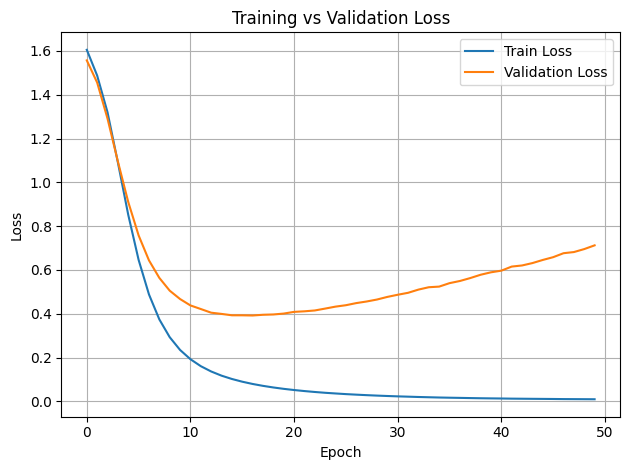


 Final Test Accuracy: 0.8345


In [2]:
import torch.nn as nn

class EmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, pad_idx, pool_type='avg', dropout_rate=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.pool_type = pool_type
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        if self.pool_type == 'max':
            pooled, _ = embedded.max(dim=1)
        else:  # default to average
            pooled = embedded.mean(dim=1)
        pooled = self.dropout(pooled)
        return self.fc(pooled)
import torch.optim as optim
import torch.nn.functional as F

def train_model(model, loaders, num_epochs=20, lr=1e-3, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in loaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(loaders['train'])
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in loaders['validation']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(loaders['validation'])
        accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.4f}")

    return train_losses, val_losses, val_accuracies
    import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate(model, loader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)
embed_dim = 100
num_classes = len(label_names)
pad_idx = vocab[PAD_TOKEN]

# Init + Train
model1 = EmotionClassifier(vocab_size, embed_dim, num_classes, pad_idx)
train_losses, val_losses, val_accuracies = train_model(model1, loaders, num_epochs=50, lr=1e-3, device=device)

# Plot
plot_losses(train_losses, val_losses)

# Test accuracy
test_acc = evaluate(model1, loaders['test'], device=device)
print(f"\n Final Test Accuracy: {test_acc:.4f}")

## First model experiment

We systematically tested different configurations to improve our MLP-based emotion classifier:

	•	Pooling: Average vs. Max
	•	Regularization: None, L1, L2
	•	Optimizers: SGD (with/without momentum), Adam, AdamW
	•	Dropout: 0.0, 0.3

Each config was trained for 20 epochs, with optional L1/L2 regularization applied. For each setup, we recorded:

	•	Training loss
	•	Validation loss
	•	Validation accuracy
	•	Test accuracy

Visualization: For every config, we plotted the training dynamics to identify trends and overfitting.

This setup helps identify the best regularization and optimization strategies for our shallow MLP classifier.


 Config: Pool=avg, Reg=none, Opt=SGD, Dropout=0.0, Momentum=0.0
epoch 1: train loss: 1.7825, validation loss: 1.7695, validation accuracy: 0.2960
epoch 2: train loss: 1.7612, validation loss: 1.7496, validation accuracy: 0.3310
epoch 3: train loss: 1.7422, validation loss: 1.7319, validation accuracy: 0.3415
epoch 4: train loss: 1.7253, validation loss: 1.7163, validation accuracy: 0.3425
epoch 5: train loss: 1.7104, validation loss: 1.7023, validation accuracy: 0.3445
epoch 6: train loss: 1.6970, validation loss: 1.6900, validation accuracy: 0.3465
epoch 7: train loss: 1.6852, validation loss: 1.6790, validation accuracy: 0.3450
epoch 8: train loss: 1.6747, validation loss: 1.6693, validation accuracy: 0.3455
epoch 9: train loss: 1.6654, validation loss: 1.6607, validation accuracy: 0.3455
epoch 10: train loss: 1.6570, validation loss: 1.6530, validation accuracy: 0.3465
epoch 11: train loss: 1.6496, validation loss: 1.6462, validation accuracy: 0.3475
epoch 12: train loss: 1.6430, v

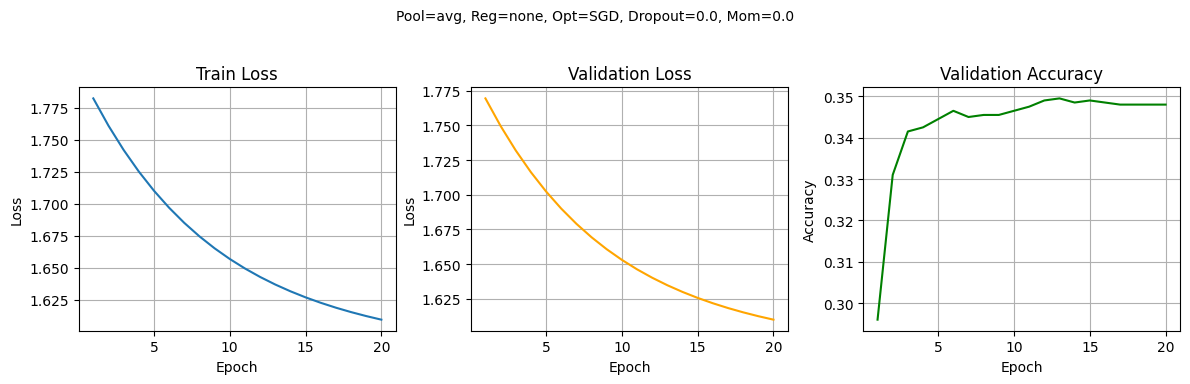


 Config: Pool=avg, Reg=none, Opt=SGD, Dropout=0.0, Momentum=0.9
epoch 1: train loss: 1.7063, validation loss: 1.6544, validation accuracy: 0.3500
epoch 2: train loss: 1.6270, validation loss: 1.6117, validation accuracy: 0.3515
epoch 3: train loss: 1.5998, validation loss: 1.5960, validation accuracy: 0.3520
epoch 4: train loss: 1.5887, validation loss: 1.5891, validation accuracy: 0.3525
epoch 5: train loss: 1.5832, validation loss: 1.5856, validation accuracy: 0.3525
epoch 6: train loss: 1.5799, validation loss: 1.5833, validation accuracy: 0.3515
epoch 7: train loss: 1.5775, validation loss: 1.5816, validation accuracy: 0.3510
epoch 8: train loss: 1.5757, validation loss: 1.5802, validation accuracy: 0.3520
epoch 9: train loss: 1.5741, validation loss: 1.5792, validation accuracy: 0.3525
epoch 10: train loss: 1.5728, validation loss: 1.5784, validation accuracy: 0.3555
epoch 11: train loss: 1.5717, validation loss: 1.5774, validation accuracy: 0.3565
epoch 12: train loss: 1.5706, v

KeyboardInterrupt: 

In [3]:
#EXPERIMENTING AND IMPROVE FIRT MODEL

import matplotlib.pyplot as plt

pooling_options = ['avg', 'max']
regularization_options = ['none', 'L1', 'L2']
optimizer_options = ['SGD', 'Adam', 'AdamW']
dropout_rates = [0.0, 0.3]
momentum_values = [0.0, 0.9]  # Only for SGD

results = {}

for pooling in pooling_options:
    for reg in regularization_options:
        for opt in optimizer_options:
            for dropout in dropout_rates:
                for momentum in momentum_values:
                    # Skip momentum if not using SGD
                    if opt != 'SGD' and momentum != 0.0:
                        continue

                    # model
                    model11 = EmotionClassifier(vocab_size, embed_dim, num_classes, pad_idx).to(device)

                    # optimizer
                    if opt == 'SGD':
                        optimizer = optim.SGD(model11.parameters(), lr=0.0005, momentum=momentum)
                    elif opt == 'Adam':
                        optimizer = optim.Adam(model11.parameters(), lr=0.0005)
                    elif opt == 'AdamW':
                        optimizer = optim.AdamW(model11.parameters(), lr=0.0005)

                    # regularization
                    weight_decay = 0.0
                    l1_lambda = 0.0
                    if reg == 'L2':
                        weight_decay = 1e-4
                    elif reg == 'L1':
                        l1_lambda = 1e-4

                    if reg == 'L2':
                        if opt == 'SGD':
                            optimizer = optim.SGD(model11.parameters(), lr=0.0005, momentum=momentum, weight_decay=weight_decay)
                        elif opt == 'Adam':
                            optimizer = optim.Adam(model11.parameters(), lr=0.0005, weight_decay=weight_decay)
                        elif opt == 'AdamW':
                            optimizer = optim.AdamW(model11.parameters(), lr=0.0005, weight_decay=weight_decay)

                    print(f"\n Config: Pool={pooling}, Reg={reg}, Opt={opt}, Dropout={dropout}, Momentum={momentum}")

                    # Train model
                    def train_model_with_l1(model, loaders, optimizer, num_epochs=10, lr=1e-3, device='cpu', l1_lambda=0.0):
                        model.to(device)
                        criterion = nn.CrossEntropyLoss()
                        train_losses, val_losses, val_accuracies = [], [], []

                        for epoch in range(1, num_epochs + 1):
                            model.train()
                            total_loss = 0
                            for inputs, labels in loaders['train']:
                                inputs, labels = inputs.to(device), labels.to(device)
                                optimizer.zero_grad()
                                outputs = model(inputs)
                                loss = criterion(outputs, labels)

                                # L1 Regularization
                                if l1_lambda > 0.0:
                                    l1_penalty = sum(torch.norm(p, 1) for p in model.parameters())
                                    loss += l1_lambda * l1_penalty

                                loss.backward()
                                optimizer.step()
                                total_loss += loss.item()

                            avg_train_loss = total_loss / len(loaders['train'])
                            train_losses.append(avg_train_loss)

                            # Validation
                            model.eval()
                            val_loss = 0
                            correct = 0
                            total = 0
                            with torch.no_grad():
                                for inputs, labels in loaders['validation']:
                                    inputs, labels = inputs.to(device), labels.to(device)
                                    outputs = model(inputs)
                                    loss = criterion(outputs, labels)
                                    val_loss += loss.item()
                                    preds = torch.argmax(outputs, dim=1)
                                    correct += (preds == labels).sum().item()
                                    total += labels.size(0)

                            avg_val_loss = val_loss / len(loaders['validation'])
                            val_accuracy = correct / total

                            val_losses.append(avg_val_loss)
                            val_accuracies.append(val_accuracy)

                            print(f"epoch {epoch}: train loss: {avg_train_loss:.4f}, validation loss: {avg_val_loss:.4f}, validation accuracy: {val_accuracy:.4f}")

                        # test accuracy
                        model.eval()
                        correct = 0
                        total = 0
                        with torch.no_grad():
                            for inputs, labels in loaders['test']:
                                inputs, labels = inputs.to(device), labels.to(device)
                                outputs = model(inputs)
                                preds = torch.argmax(outputs, dim=1)
                                correct += (preds == labels).sum().item()
                                total += labels.size(0)
                        test_accuracy = correct / total
                        print(f"Test Accuracy: {test_accuracy:.4f}")

                        return train_losses, val_losses, val_accuracies


                    train_losses, val_losses, val_accuracies = train_model_with_l1(
                        model11, loaders, optimizer, num_epochs=20, lr=0.0005, device=device, l1_lambda=l1_lambda
                        )

                    config_key = (pooling, reg, opt, dropout, momentum)
                    results[config_key] = {
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'val_accuracies': val_accuracies
                    }

                    # Plotting
                    epochs = range(1, len(train_losses) + 1)
                    plt.figure(figsize=(12, 4))

                    plt.subplot(1, 3, 1)
                    plt.plot(epochs, train_losses, label='Train Loss')
                    plt.title('Train Loss')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss')
                    plt.grid(True)

                    plt.subplot(1, 3, 2)
                    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
                    plt.title('Validation Loss')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss')
                    plt.grid(True)

                    plt.subplot(1, 3, 3)
                    plt.plot(epochs, val_accuracies, label='Val Acc', color='green')
                    plt.title('Validation Accuracy')
                    plt.xlabel('Epoch')
                    plt.ylabel('Accuracy')
                    plt.grid(True)

                    plt.suptitle(f"Pool={pooling}, Reg={reg}, Opt={opt}, Dropout={dropout}, Mom={momentum}", fontsize=10)
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    plt.show()


## First model's interpretability



To understand how our MLP emotion classifier makes decisions, we used both intrinsic and post-hoc interpretability methods:

##	 Intrinsic:
print_top_words() identifies the top words most associated with each emotion class based on the classifier’s learned weights.

The model highlights words most influential for each emotion

	•	Class 0 (e.g., sadness): gloomy, deprived, burdened…
	•	Class 1 (e.g., joy): ecstatic, intelligent, successful…
	•	Class 2 (e.g., love): fond, compassionate, nostalgic…
	•	Class 3 (e.g., anger): pissed, cranky, grouchy…
	•	Class 4 (e.g., fear): frantic, hesitant, paranoid…
	•	Class 5 (e.g., surprise): amazed, stunned, overwhelmed…

##	 Interactive Testing:

classify_interactively() allows live predictions and prints class probabilities for user input text.

	•	Input: “you are so mean!”
	•	Predicted Emotion: Class 0 (e.g., sadness) with 57% confidence
	•	Shows full class probability breakdown.
  
##	 LIME (Post-hoc):

explain_with_lime() highlights which words influenced the prediction the most for a given sentence using the LIME framework.
Input: “I feel miserable and alone”

	•	LIME highlights “miserable” and “alone” as most impactful.
	•	These words are strongly associated with class 0.
	•	Explains how individual tokens contribute to prediction.

These methods help us peek inside the black box and make the model’s behavior more transparent.



In [4]:
# Interpretability
import torch
import numpy as np
from lime.lime_text import LimeTextExplainer

# PREPROCESS FUNCTION FOR LIME & INTERACTIVE
def preprocess_fn(text, max_len=MAX_LEN):
    tokens = tokenize(text)
    token_ids = [vocab.get(token, vocab[OOV_TOKEN]) for token in tokens]
    token_ids = token_ids[:max_len] + [vocab[PAD_TOKEN]] * max(0, max_len - len(token_ids))
    return torch.tensor(token_ids, dtype=torch.long)

# INTERACTIVE CLASSIFICATION
def classify_interactively(model, label_map):
    print("\nType a sentence to classify its emotion. Type 'exit' to quit.")
    while True:
        text = input("Enter text: ")
        if text.lower() == 'exit':
            break
        tokens = preprocess_fn(text).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(tokens)
            probs = torch.softmax(logits, dim=1).squeeze()
            pred = torch.argmax(probs).item()
        print(f"Prediction: {label_map[pred]} ({probs[pred]:.2f})")
        print("Top class probabilities:")
        for i, p in enumerate(probs):
            print(f"  {label_map[i]}: {p:.2f}")

# CLASS-WORD ASSOCIATION (INTRINSIC)
def print_top_words(model, id2word, class_names, top_n=10):
    weights = model.fc.weight.detach().cpu().numpy()
    embed_weights = model.embedding.weight.detach().cpu().numpy()

    for i, label in enumerate(class_names):
        sims = embed_weights @ weights[i]
        top_indices = sims.argsort()[-top_n:][::-1]
        top_words = [id2word.get(idx, '?') for idx in top_indices]
        print(f"\nTop {top_n} indicative words for '{label}':\n  {' '.join(top_words)}")

# LIME INTERPRETABILITY (POST-HOC)
class WrappedModel:
    def __init__(self, model, label_map):
        self.model = model
        self.label_map = label_map
        self.model.eval()

    def predict_proba(self, texts):
        outputs = []
        for text in texts:
            tokens = preprocess_fn(text).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = self.model(tokens)
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            outputs.append(probs)
        return np.stack(outputs)

def explain_with_lime(text, model, label_names):
    explainer = LimeTextExplainer(class_names=label_names)
    wrapped = WrappedModel(model, label_names)
    explanation = explainer.explain_instance(text, wrapped.predict_proba, num_features=6)
    explanation.show_in_notebook()

# Intrinsic: top words per emotion class
print_top_words(model1, id2word, label_names, top_n=10)

# Interactive classifier
classify_interactively(model1, label_names)

# Post-hoc: LIME explanation for a specific sentence
example_text = "I feel miserable and alone"
explain_with_lime(example_text, model1, label_names)

ModuleNotFoundError: No module named 'lime'

# Second model

## BoW + MLP Classifier

##Model Overview

	•	Architecture: Bag-of-Words (BoW) vectorization → Fully connected MLP (2 layers with ReLU and dropout)
	•	Input: Sparse BoW vectors with max 5000 features representing word counts
	•	Output: Emotion classes (same 6 labels as before)

##Training Setup

	•	Optimizer: Adam with learning rate = 1e-3
	•	Loss: CrossEntropyLoss (for multi-class classification)
	•	Epochs: 10
	•	Batch Size: 32

##Results

	•	Best Validation Accuracy: Around 88.95% (early epochs, around epoch 5)
	•	Final Test Accuracy: About 84.3%
  
	•	Training Trend:
	•	Training loss steadily decreases across epochs, showing good fitting
	•	Validation loss starts to increase after about 10-15 epochs, indicating overfitting
	•	Validation accuracy peaks early and then slightly declines or plateaus
	•	Overfitting: Clear signs after early epochs, model learns training data well but generalizes less as epochs progress

##Conclusion

This BoW + MLP model is a simple but effective baseline for text emotion classification. It leverages word count features instead of learned embeddings, making it fast to train and interpret. However, it is prone to overfitting if trained for too long.



Epoch 1/10 - Train Loss: 0.9375, Val Loss: 0.3991, Val Acc: 0.8835
Epoch 2/10 - Train Loss: 0.2147, Val Loss: 0.3309, Val Acc: 0.8900
Epoch 3/10 - Train Loss: 0.1114, Val Loss: 0.3565, Val Acc: 0.8830
Epoch 4/10 - Train Loss: 0.0730, Val Loss: 0.3854, Val Acc: 0.8810
Epoch 5/10 - Train Loss: 0.0526, Val Loss: 0.4147, Val Acc: 0.8840
Epoch 6/10 - Train Loss: 0.0396, Val Loss: 0.4550, Val Acc: 0.8820
Epoch 7/10 - Train Loss: 0.0329, Val Loss: 0.4818, Val Acc: 0.8790
Epoch 8/10 - Train Loss: 0.0287, Val Loss: 0.5289, Val Acc: 0.8770
Epoch 9/10 - Train Loss: 0.0237, Val Loss: 0.5457, Val Acc: 0.8790
Epoch 10/10 - Train Loss: 0.0228, Val Loss: 0.5903, Val Acc: 0.8785
Test Accuracy: 0.8550


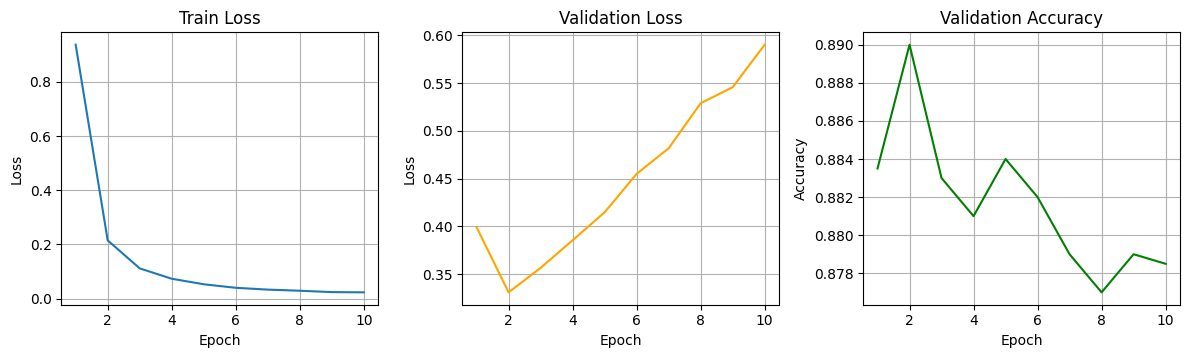


 Best Validation Accuracy: 0.8900 (at epoch 2)


In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# 1. Load data using pandas from HuggingFace
splits = {
    'train': 'split/train-00000-of-00001.parquet',
    'validation': 'split/validation-00000-of-00001.parquet',
    'test': 'split/test-00000-of-00001.parquet'
}

df = {
    split: pd.read_parquet(f"hf://datasets/dair-ai/emotion/{path}")
    for split, path in splits.items()
}

# 2. Encode labels
label_encoder = LabelEncoder()
df['train']['label_encoded'] = label_encoder.fit_transform(df['train']['label'])
df['validation']['label_encoded'] = label_encoder.transform(df['validation']['label'])

# 3. Vectorize using BoW
vectorizer = CountVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(df['train']['text']).toarray()
X_val = vectorizer.transform(df['validation']['text']).toarray()
X_test = vectorizer.transform(df['test']['text']).toarray()

y_train = df['train']['label_encoded'].values
y_val = df['validation']['label_encoded'].values
y_test = label_encoder.transform(df['test']['label'])

# 4. Convert to PyTorch Dataset
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)
test_dataset = EmotionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

loaders = {
    'train': train_loader,
    'validation': val_loader,
    'test': test_loader
}

# 5. BoW MLP Classifier
class BoWEmotionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# Initialize model
model2 = BoWEmotionClassifier(input_dim=5000, hidden_dim=128, num_classes=len(label_encoder.classes_))

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        accuracy = accuracy_score(all_labels, all_preds)

        val_losses.append(avg_val_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.4f}")

    # Test accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    test_accuracy = correct / total
    print(f"Test Accuracy: {test_accuracy:.4f}")


    # Plot
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_accuracies, label='Val Acc', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return train_losses, val_losses, val_accuracies


train_losses, val_losses, val_accuracies = train_model(model2, train_loader, val_loader, num_epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu')

best_val_acc = max(val_accuracies)
best_epoch = val_accuracies.index(best_val_acc) + 1
print(f"\n Best Validation Accuracy: {best_val_acc:.4f} (at epoch {best_epoch})")

## Second model experiment

##Hyperparameter Tuning on BoW + MLP

**Goal**: Improve model performance by testing combinations of regularization, optimizers, dropout, and momentum.

**Configs Tested:**

	•	Pooling: Average vs. Max
	•	Regularization: None, L1, L2
	•	Optimizers: SGD (with/without momentum), Adam, AdamW
	•	Dropout: 0.0, 0.3

Each config was trained for 10 epochs, with optional L1/L2 regularization applied. For each setup, we recorded:

	•	Training loss
	•	Validation loss
	•	Validation accuracy
	•	Test accuracy

Visualization: For every config, we plotted the training dynamics to identify trends and overfitting.


In [6]:
# EXPERIMENT AND IMPROVE SECOND MODEL

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameter options
regularization_options = ['none', 'L1', 'L2']
optimizer_options = ['SGD', 'Adam', 'AdamW']
dropout_rates = [0.0, 0.3]
momentum_values = [0.0, 0.9]  # Only SGD

results = {}

# Training loop
for reg in regularization_options:
    for opt in optimizer_options:
        for dropout in dropout_rates:
            for momentum in momentum_values:
                if opt != 'SGD' and momentum != 0.0:
                    continue

                print(f"\n Config: Reg={reg}, Opt={opt}, Dropout={dropout}, Momentum={momentum}")

                # Initialize model
                model = BoWEmotionClassifier(input_dim=5000, hidden_dim=128,
                                             num_classes=len(label_encoder.classes_),
                                             dropout=dropout).to(device)

                # Set regularization parameters
                weight_decay = 0.0
                l1_lambda = 0.0
                if reg == 'L2':
                    weight_decay = 1e-4
                elif reg == 'L1':
                    l1_lambda = 1e-4

                # Define optimizer with correct regularization
                if opt == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=momentum, weight_decay=weight_decay)
                elif opt == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=weight_decay)
                elif opt == 'AdamW':
                    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=weight_decay)

                # Define training function
                def train_model_with_l1(model, loaders, optimizer, num_epochs=10, device='cpu', l1_lambda=0.0):
                    model.to(device)
                    criterion = nn.CrossEntropyLoss()
                    train_losses, val_losses, val_accuracies = [], [], []

                    for epoch in range(1, num_epochs + 1):
                        model.train()
                        total_loss = 0
                        for inputs, labels in loaders['train']:
                            inputs, labels = inputs.to(device), labels.to(device)
                            optimizer.zero_grad()
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                            if l1_lambda > 0.0:
                                l1_penalty = sum(torch.norm(p, 1) for p in model.parameters())
                                loss += l1_lambda * l1_penalty

                            loss.backward()
                            optimizer.step()
                            total_loss += loss.item()

                        avg_train_loss = total_loss / len(loaders['train'])
                        train_losses.append(avg_train_loss)

                        # Validation
                        model.eval()
                        val_loss = 0
                        correct = 0
                        total = 0
                        with torch.no_grad():
                            for inputs, labels in loaders['validation']:
                                inputs, labels = inputs.to(device), labels.to(device)
                                outputs = model(inputs)
                                loss = criterion(outputs, labels)
                                val_loss += loss.item()
                                preds = torch.argmax(outputs, dim=1)
                                correct += (preds == labels).sum().item()
                                total += labels.size(0)

                        avg_val_loss = val_loss / len(loaders['validation'])
                        val_accuracy = correct / total
                        val_losses.append(avg_val_loss)
                        val_accuracies.append(val_accuracy)

                        print(f"epoch {epoch}: train loss: {avg_train_loss:.4f}, val loss: {avg_val_loss:.4f}, val acc: {val_accuracy:.4f}")


                    model.eval()
                    correct = 0
                    total = 0
                    with torch.no_grad():
                        for inputs, labels in loaders['test']:
                            inputs, labels = inputs.to(device), labels.to(device)
                            outputs = model(inputs)
                            preds = torch.argmax(outputs, dim=1)
                            correct += (preds == labels).sum().item()
                            total += labels.size(0)
                    test_accuracy = correct / total
                    print(f"Test Accuracy: {test_accuracy:.4f}")

                    return train_losses, val_losses, val_accuracies

                # Train and collect results
                train_losses, val_losses, val_accuracies = train_model_with_l1(
                    model, loaders, optimizer, num_epochs=20, device=device, l1_lambda=l1_lambda
                )

                config_key = (reg, opt, dropout, momentum)
                results[config_key] = {
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'val_accuracies': val_accuracies
                }

                # Plot
                epochs = range(1, len(train_losses) + 1)
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.plot(epochs, train_losses, label='Train Loss')
                plt.title('Train Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.grid(True)

                plt.subplot(1, 3, 2)
                plt.plot(epochs, val_losses, label='Val Loss', color='orange')
                plt.title('Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.grid(True)

                plt.subplot(1, 3, 3)
                plt.plot(epochs, val_accuracies, label='Val Acc', color='green')
                plt.title('Validation Accuracy')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.grid(True)

                plt.suptitle(f"Reg={reg}, Opt={opt}, Dropout={dropout}, Mom={momentum}", fontsize=10)
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()



 Config: Reg=none, Opt=SGD, Dropout=0.0, Momentum=0.0
epoch 1: train loss: 1.7899, val loss: 1.7757, val acc: 0.3450
epoch 2: train loss: 1.7665, val loss: 1.7534, val acc: 0.3520
epoch 3: train loss: 1.7447, val loss: 1.7325, val acc: 0.3520
epoch 4: train loss: 1.7246, val loss: 1.7132, val acc: 0.3520
epoch 5: train loss: 1.7059, val loss: 1.6955, val acc: 0.3520


KeyboardInterrupt: 

## Second model's interpretability

In [ ]:
# Interpretability
import torch
import numpy as np
from lime.lime_text import LimeTextExplainer

# PREPROCESS FUNCTION FOR LIME & INTERACTIVE
def preprocess_fn(text):
    vector = vectorizer.transform([text]).toarray()[0]
    return torch.tensor(vector, dtype=torch.float32)

# INTERACTIVE CLASSIFICATION
def classify_interactively(model, label_map):
    print("\nType a sentence to classify its emotion. Type 'exit' to quit.")
    while True:
        text = input("Enter text: ")
        if text.lower() == 'exit':
            break
        tokens = preprocess_fn(text).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(tokens)
            probs = torch.softmax(logits, dim=1).squeeze()
            pred = torch.argmax(probs).item()
        print(f"Prediction: {label_map[pred]} ({probs[pred]:.2f})")
        print("Top class probabilities:")
        for i, p in enumerate(probs):
            print(f"  {label_map[i]}: {p:.2f}")

# CLASS-WORD ASSOCIATION (INTRINSIC)
def print_top_words(model, vectorizer, class_names, top_n=10):
    weights = model.fc2.weight.detach().cpu().numpy()
    feature_names = vectorizer.get_feature_names_out()

    input_weights = model.fc1.weight.detach().cpu().numpy()
    combined_weights = weights @ input_weights

    for i, class_name in enumerate(class_names):
        top_indices = combined_weights[i].argsort()[-top_n:][::-1]
        top_words = [feature_names[idx] for idx in top_indices]
        print(f"\nTop {top_n} indicative words for '{class_name}':")
        print("  " + ", ".join(top_words))


# LIME INTERPRETABILITY (POST-HOC)
class WrappedModel:
    def __init__(self, model, label_map):
        self.model = model
        self.label_map = label_map
        self.model.eval()

    def predict_proba(self, texts):
        outputs = []
        for text in texts:
            tokens = preprocess_fn(text).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = self.model(tokens)
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            outputs.append(probs)
        return np.stack(outputs)

def explain_with_lime(text, model, label_names):
    explainer = LimeTextExplainer(class_names=label_names)
    wrapped = WrappedModel(model, label_names)
    explanation = explainer.explain_instance(text, wrapped.predict_proba, num_features=6)
    explanation.show_in_notebook()

# Intrinsic: top words per emotion class
class_names = label_encoder.classes_
print_top_words(model2, vectorizer, class_names, top_n=10)

# Interactive classifier
classify_interactively(model2, label_names)

# Post-hoc: LIME explanation for a specific sentence
example_text = "I feel miserable and alone"
explain_with_lime(example_text, model2, label_names)

# Third model: transfomer

In [ ]:

import torch
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader # Import DataLoader and TensorDataset here

splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
dataset = {
    split: pd.read_parquet(f"hf://datasets/dair-ai/emotion/{path}")
    for split, path in splits.items()
}
label_names = sorted(dataset["train"]["label"].unique())
label_names = [str(lbl) for lbl in label_names]  # In case labels are ints

def label_stats(split):
    # Ensure dataset[split] is a DataFrame here
    if not isinstance(dataset[split], pd.DataFrame):
        print(f"Warning: dataset['{split}'] is not a DataFrame when calling label_stats.")
        # You might need to handle this case if label_stats is called after tensor conversion
        # For this fix, we assume label_stats is called before the conversion.
        return [], Counter() # Return empty results if not a DataFrame

    labels = dataset[split]["label"].tolist()
    counts = Counter(labels)
    print(f"\n[{split.upper()}] Label Counts:")
    for label, count in sorted(counts.items()):
        # Ensure label is within the bounds of label_names
        if label < len(label_names):
            print(f"{label_names[label]:>10}: {count}")
        else:
            print(f"Unknown label ({label}): {count}")
    return labels, counts

# Re-define splits as a list after the dictionary definition
splits = ['train', 'validation', 'test']
split_labels = {}
for split in splits:
    split_labels[split], counts = label_stats(split)

# Ensure index is within bounds
if most_common_class[0] < len(label_names):
    print(f"Majority class baseline accuracy: {majority_accuracy:.2f} ({label_names[most_common_class[0]]})")
else:
     print(f"Majority class baseline accuracy: {majority_accuracy:.2f} (Unknown label)")


# STEP 2: Tokenization
def tokenize(text):
    return text.lower().split()

# Apply tokenization while dataset is still a DataFrame
for split in splits:
    # Ensure dataset[split] is a DataFrame before applying .apply()
    if isinstance(dataset[split], pd.DataFrame):
        dataset[split]["tokens"] = dataset[split]["text"].apply(tokenize)
    else:
        print(f"Warning: dataset['{split}'] is not a DataFrame during tokenization.")

# Text length stats
# Calculate lengths while dataset[split] is still a DataFrame with a 'tokens' column
lengths = {split: [len(ex['tokens']) for _, ex in dataset[split].iterrows()] for split in splits if isinstance(dataset[split], pd.DataFrame)} # Iterate over rows if it's a DataFrame
for split in splits:
    if split in lengths: # Check if length data was collected for this split
        lens = lengths[split]
        print(f"\n{split.capitalize()} text length - Min: {min(lens)}, Max: {max(lens)}, Mean: {np.mean(lens):.2f}, Std: {np.std(lens):.2f}")
    else:
        print(f"\nCould not calculate text length stats for {split.capitalize()} (not a DataFrame).")


# STEP 3: Build vocabulary
PAD_TOKEN = "<PAD>"
OOV_TOKEN = "<OOV>"

# Flatten all tokens in train split
# Ensure dataset['train'] is a DataFrame before accessing 'tokens'
all_tokens = []
if isinstance(dataset['train'], pd.DataFrame):
    all_tokens = [token for example in dataset['train']['tokens'] for token in example]
else:
    print("\nWarning: dataset['train'] is not a DataFrame. Cannot build vocabulary from tokens.")

vocab = {PAD_TOKEN: 0, OOV_TOKEN: 1}
if all_tokens: # Only build vocab if tokens were collected
    for token in set(all_tokens):
        vocab[token] = len(vocab)

# Reverse vocab
id2word = {idx: word for word, idx in vocab.items()}

print(f"\nVocabulary size: {len(vocab)}")

# STEP 4: Encode texts with OOV handling
def encode_tokens(tokens, vocab):
    return [vocab.get(token, vocab[OOV_TOKEN]) for token in tokens]

for split in splits:
    # Ensure dataset[split] is a DataFrame before applying .apply()
    if isinstance(dataset[split], pd.DataFrame):
        dataset[split]["input_ids"] = dataset[split]["tokens"].apply(lambda tokens: encode_tokens(tokens, vocab))
    else:
         print(f"Warning: dataset['{split}'] is not a DataFrame during encoding.")


# STEP 5: Padding and tensor conversion
# Use MAX_LEN calculated from the 'lengths' dictionary
# Check if 'lengths' was successfully populated
if 'train' in lengths:
    MAX_LEN = int(np.percentile(lengths['train'], 95))
else:
    MAX_LEN = 50 # Fallback value if lengths could not be calculated
    print(f"Warning: Could not determine MAX_LEN from lengths. Using default: {MAX_LEN}")


def pad_sequence(seq, max_len, pad_val):
    # Ensure seq is a list
    if not isinstance(seq, list):
        print(f"Warning: pad_sequence received non-list input: {type(seq)}")
        return [] # Return empty list if input is not list
    return seq[:max_len] + [pad_val] * max(0, max_len - len(seq))

# This is where the dataset is converted from DataFrame to dictionary of tensors
for split in splits:
    inputs = []
    labels = []
    # Ensure dataset[split] is a DataFrame with necessary columns before iteration
    if isinstance(dataset[split], pd.DataFrame) and 'input_ids' in dataset[split].columns and 'label' in dataset[split].columns:
        for index, example in dataset[split].iterrows(): # Iterate over DataFrame rows
            # Ensure 'input_ids' is a list before padding
            input_ids_list = example['input_ids']
            if not isinstance(input_ids_list, list):
                 print(f"Warning: input_ids for example in {split} is not a list: {type(input_ids_list)}")
                 input_ids_list = [] # Use empty list if not a list

            padded = pad_sequence(input_ids_list, MAX_LEN, vocab.get(PAD_TOKEN, -1)) # Use .get() for PAD_TOKEN to be safe, fallback to -1
            inputs.append(padded)
            labels.append(example['label'])

        inputs_tensor = torch.tensor(inputs)
        labels_tensor = torch.tensor(labels)
        dataset[split] = {'inputs': inputs_tensor, 'labels': labels_tensor}
    else:
        print(f"Warning: dataset['{split}'] is not a DataFrame with 'input_ids' and 'label' columns. Skipping tensor conversion for this split.")
        # If conversion failed, ensure dataset[split] is not expected to be tensors later
        # Depending on the rest of the pipeline, you might want to remove this split from 'loaders' later

# Create DataLoaders
batch_size = 32
loaders = {}
for split in splits:
    # Check if dataset[split] has the expected structure (dictionary with 'inputs' and 'labels' tensors)
    if isinstance(dataset[split], dict) and 'inputs' in dataset[split] and 'labels' in dataset[split] and isinstance(dataset[split]['inputs'], torch.Tensor) and isinstance(dataset[split]['labels'], torch.Tensor):
        tensor_dataset = TensorDataset(dataset[split]['inputs'], dataset[split]['labels'])
        shuffle = True if split == 'train' else False
        loaders[split] = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        print(f"Warning: Could not create DataLoader for {split}. Dataset structure not as expected.")


print("\n Data preparation complete. Loaders are ready!")


[TRAIN] Label Counts:
         0: 4666
         1: 5362
         2: 1304
         3: 2159
         4: 1937
         5: 572

[VALIDATION] Label Counts:
         0: 550
         1: 704
         2: 178
         3: 275
         4: 212
         5: 81

[TEST] Label Counts:
         0: 581
         1: 695
         2: 159
         3: 275
         4: 224
         5: 66
Majority class baseline accuracy: 0.34 (1)

Train text length - Min: 2, Max: 66, Mean: 19.17, Std: 10.99

Validation text length - Min: 2, Max: 61, Mean: 18.87, Std: 10.81

Test text length - Min: 3, Max: 61, Mean: 19.15, Std: 11.01

Vocabulary size: 15214

 Data preparation complete. Loaders are ready!



##Transformer-Based Classifier

We trained a Transformer-based neural network for classifying emotions in tweets using the Emotion dataset.

**Model Overview**

	•	Architecture: Embedding + Positional Encoding → Transformer Encoder (2 layers, 4 heads) → Mean Pooling → Linear classifier
	•	Type: Deep Transformer encoder-based model for sequence classification

**Training Setup**

	•	Optimizer: AdamW, LR = 2e-4
	•	Loss: CrossEntropy
	•	Epochs: 10
	•	Device: CPU/GPU (auto-selected)

**Results**

	•	Initial Val Accuracy: 53.3% (Epoch 0)
	•	Peak Val Accuracy: ~86.65% (around Epochs 6-7)
	•	Final Test Accuracy: 86.20%
	•	Training Loss: Decreased steadily from ~1.5 to ~0.12 in first 10 epochs
	•	Validation Loss: Initially drops, then stabilizes around 0.38-0.46 after epoch 4-5
	•	Trend: Model learns quickly in early epochs, then stabilizes with minor fluctuations in validation metrics
	•	Overall Accuracy: 86.20%
	•	Macro F1-score: ~0.81

**Conclusion**

This Transformer model effectively classifies emotions with solid accuracy and balanced precision/recall across labels.

The deep self-attention layers enable nuanced understanding of tweet semantics compared to simpler baselines.

This model provides a strong foundation for further improvements like deeper layers, fine-tuning, or augmented data.


epoch 0: train loss: 1.5032, val loss: 1.2670, val acc: 53.30%
epoch 1: train loss: 0.9626, val loss: 0.6917, val acc: 76.60%
epoch 2: train loss: 0.5392, val loss: 0.4597, val acc: 84.10%
epoch 3: train loss: 0.3660, val loss: 0.4141, val acc: 85.35%
epoch 4: train loss: 0.2869, val loss: 0.4025, val acc: 86.15%
epoch 5: train loss: 0.2351, val loss: 0.3848, val acc: 86.35%
epoch 6: train loss: 0.1936, val loss: 0.4028, val acc: 86.65%
epoch 7: train loss: 0.1637, val loss: 0.4314, val acc: 86.65%
epoch 8: train loss: 0.1442, val loss: 0.4536, val acc: 86.35%
epoch 9: train loss: 0.1229, val loss: 0.4633, val acc: 86.30%
Test Accuracy: 0.8620


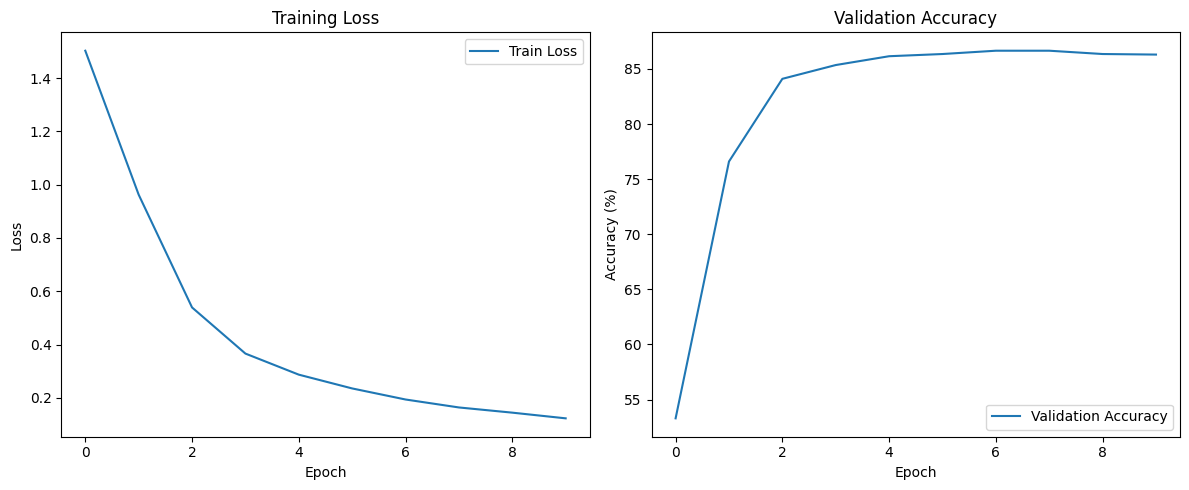


Classification Report:
              precision    recall  f1-score   support

           0     0.8762    0.9380    0.9061       581
           1     0.8986    0.8921    0.8953       695
           2     0.7755    0.7170    0.7451       159
           3     0.8845    0.8073    0.8441       275
           4     0.8080    0.8080    0.8080       224
           5     0.6364    0.6364    0.6364        66

    accuracy                         0.8620      2000
   macro avg     0.8132    0.7998    0.8058      2000
weighted avg     0.8616    0.8620    0.8611      2000



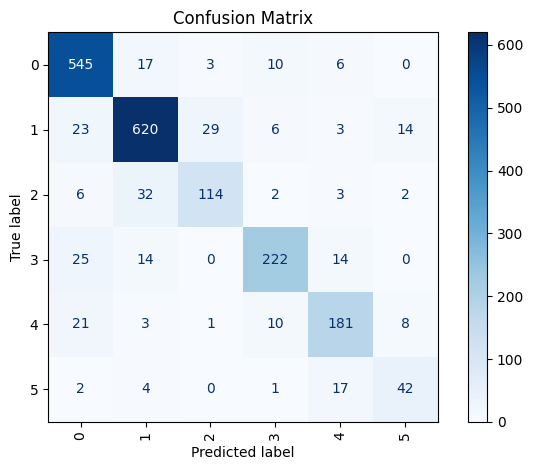

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_classes, num_layers, dropout=0.1, max_len=128):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        seq_len = x.size(1)
        x = self.embedding(x) + self.pos_embedding[:, :seq_len]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Mean pooling
        return self.classifier(x)

# Instantiate model
model = TransformerClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    num_heads=4,
    hidden_dim=256,
    num_classes=6,
    num_layers=2,
    max_len=128
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

# Loaders
train_loader = loaders['train']
val_loader = loaders['validation']
test_loader = loaders['test']

# For plotting
train_losses, val_accuracies = [], []

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for input_ids, labels in train_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)

        outputs = model(input_ids)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for input_ids, labels in val_loader:
            input_ids, labels = input_ids.to(device), labels.to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total * 100
    val_accuracies.append(val_accuracy)

    print(f"epoch {epoch}: train loss: {avg_train_loss:.4f}, val loss: {avg_val_loss:.4f}, val acc: {val_accuracy:.2f}%")


# Final test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in loaders['test']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    preds = torch.argmax(outputs, dim=1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation on Test Set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for input_ids, labels in test_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## Third model experiment








## Third model's interpretability


Type a sentence to classify its emotion. Type 'exit' to quit.
Enter text: what a lovely day!
Prediction: 1 (0.96)
Top class probabilities:
  0: 0.01
  1: 0.96
  2: 0.03
  3: 0.00
  4: 0.00
  5: 0.00
Enter text: exit


<ipython-input-48-00d77c67ce4e>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=scores, palette="coolwarm")


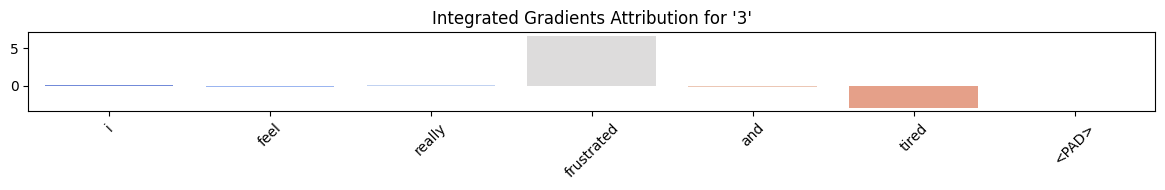

In [ ]:
# Interpretability
import numpy as np
from lime.lime_text import LimeTextExplainer
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import seaborn as sns

# Helper for Raw Text Prediction
def preprocess_fn_transformer(text, max_len=128):
    tokens = tokenize(text.lower())
    token_ids = [vocab.get(token, vocab[OOV_TOKEN]) for token in tokens]
    token_ids = token_ids[:max_len] + [vocab[PAD_TOKEN]] * max(0, max_len - len(token_ids))
    return torch.tensor(token_ids, dtype=torch.long)

# Interactive Classification
def classify_interactively(model, label_map):
    print("\nType a sentence to classify its emotion. Type 'exit' to quit.")
    while True:
        text = input("Enter text: ")
        if text.lower() == 'exit':
            break
        input_tensor = preprocess_fn_transformer(text).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1).squeeze()
            pred = torch.argmax(probs).item()
        print(f"Prediction: {label_map[pred]} ({probs[pred]:.2f})")
        print("Top class probabilities:")
        for i, p in enumerate(probs):
            print(f"  {label_map[i]}: {p:.2f}")

#  LIME Wrapper
from lime.lime_text import LimeTextExplainer
import numpy as np

class WrappedTransformerModel:
    def __init__(self, model):
        self.model = model.eval()

    def predict_proba(self, texts):
        results = []
        for text in texts:
            input_tensor = preprocess_fn_transformer(text).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = self.model(input_tensor)
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            results.append(probs)
        return np.stack(results)

def explain_with_lime(text, model, label_names):
    explainer = LimeTextExplainer(class_names=label_names)
    wrapped = WrappedTransformerModel(model)
    explanation = explainer.explain_instance(text, wrapped.predict_proba, num_features=8)
    explanation.show_in_notebook()


# Integrated Gradients
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import seaborn as sns

def explain_with_integrated_gradients(text, model, label_idx, label_names):
    model.eval()

    # Tokenize input text and get input IDs (LongTensor)
    input_ids = preprocess_fn_transformer(text).unsqueeze(0).to(device)

    # embeddings
    embeddings = model.embedding(input_ids) + model.pos_embedding[:, :input_ids.size(1)]
    embeddings.requires_grad_()

    def forward_embedded(x_emb):
        x = model.transformer_encoder(x_emb)
        x = x.mean(dim=1)  # mean pooling
        return model.classifier(x)

    ig = IntegratedGradients(forward_embedded)
    baseline = torch.zeros_like(embeddings).to(device)

    attributions = ig.attribute(
        inputs=embeddings,
        baselines=baseline,
        target=label_idx,
        return_convergence_delta=False,
        internal_batch_size=1,
        n_steps=50
    )

    token_ids = input_ids[0].cpu().tolist()
    tokens = [id2word.get(idx, '<unk>') for idx in token_ids]
    scores = attributions.squeeze(0).sum(dim=1).cpu().detach().numpy()  # attribution per token

    plt.figure(figsize=(12, 2))
    sns.barplot(x=tokens, y=scores, palette="coolwarm")
    plt.title(f"Integrated Gradients Attribution for '{label_names[label_idx]}'")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 1. Interactive use
classify_interactively(model, label_names)

# 2. LIME
explain_with_lime("I feel really frustrated and tired", model, label_names)

# 3. Integrated Gradients
text = "I feel really frustrated and tired"
input_ids = preprocess_fn_transformer(text).unsqueeze(0).to(device)
with torch.no_grad():
    pred_label = torch.argmax(model(input_ids), dim=1).item()
explain_with_integrated_gradients(text, model, label_idx=pred_label, label_names=label_names)


# Pre-trained language model

We fine-tuned a pretrained BERT-base-uncased model for classifying emotions in tweets using the Emotion dataset.

**Model** **Overview**

	•	Architecture: Pretrained BERT with a classification head (BertForSequenceClassification)
	•	Type: Transformer-based deep model with contextual embeddings

**Training** Setup

	•	Optimizer: AdamW, LR = 2e-5
	•	Loss: CrossEntropy
	•	Epochs: 3
	•	Batch Size: 16 (train), 64 (eval)
	•	Device: GPU (if available)

**Results**

	•	Best Val Accuracy: 93.8% (Epoch 3)
	•	Final Test Accuracy: 92.9%
	•	Trend: Steady decrease in training and validation loss, no overfitting observed

**Conclusion**

The pretrained BERT model performs strongly on emotion classification, achieving high accuracy and balanced precision/recall across classes. Class imbalance affects minority classes (e.g., label 5) but overall it’s a robust and reliable baseline outperforming simpler models.


In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
from collections import Counter
import numpy as np

# 1) Load parquet data into pandas DataFrames
splits = {
    'train': 'split/train-00000-of-00001.parquet',
    'validation': 'split/validation-00000-of-00001.parquet',
    'test': 'split/test-00000-of-00001.parquet'
}

dataset = {
    split: pd.read_parquet(f"hf://datasets/dair-ai/emotion/{path}")
    for split, path in splits.items()
}

for split in splits:
    counts = Counter(dataset[split]['label'])
    print(f"\n[{split.upper()}] Label counts:")
    for label, count in sorted(counts.items()):
        print(f"  Label {label}: {count}")

# 2) Convert pandas DataFrames to HuggingFace Dataset objects
def pandas_to_hf_dataset(df):
    if 'text' not in df.columns:
        raise ValueError("DataFrame must have a 'text' column with raw text!")
    return Dataset.from_pandas(df)

hf_datasets = DatasetDict({
    split: pandas_to_hf_dataset(dataset[split])
    for split in splits
})

print(f"\nSample example from train split:\n{hf_datasets['train'][0]}")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

hf_datasets = hf_datasets.map(tokenize_function, batched=True)

print(hf_datasets['train'].features)

import torch

def format_for_torch(example):
    return {
        "input_ids": torch.tensor(example["input_ids"], dtype=torch.long),
        "attention_mask": torch.tensor(example["attention_mask"], dtype=torch.long),
        "label": torch.tensor(example["label"], dtype=torch.long),
    }

hf_datasets['train'] = hf_datasets['train'].map(format_for_torch)
hf_datasets['validation'] = hf_datasets['validation'].map(format_for_torch)
hf_datasets['test'] = hf_datasets['test'].map(format_for_torch)

label_list = sorted(dataset['train']['label'].unique())
num_labels = len(label_list)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to=[]
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = np.mean(preds == labels)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_datasets['train'],
    eval_dataset=hf_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

# Test evaluation
test_results = trainer.evaluate(hf_datasets['test'])
print(f"\nTest accuracy: {test_results['eval_accuracy']:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



[TRAIN] Label counts:
  Label 0: 4666
  Label 1: 5362
  Label 2: 1304
  Label 3: 2159
  Label 4: 1937
  Label 5: 572

[VALIDATION] Label counts:
  Label 0: 550
  Label 1: 704
  Label 2: 178
  Label 3: 275
  Label 4: 212
  Label 5: 81

[TEST] Label counts:
  Label 0: 581
  Label 1: 695
  Label 2: 159
  Label 3: 275
  Label 4: 224
  Label 5: 66

Sample example from train split:
{'text': 'i didnt feel humiliated', 'label': 0}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-1-7d59e4d97c47>:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Test accuracy: 0.9290


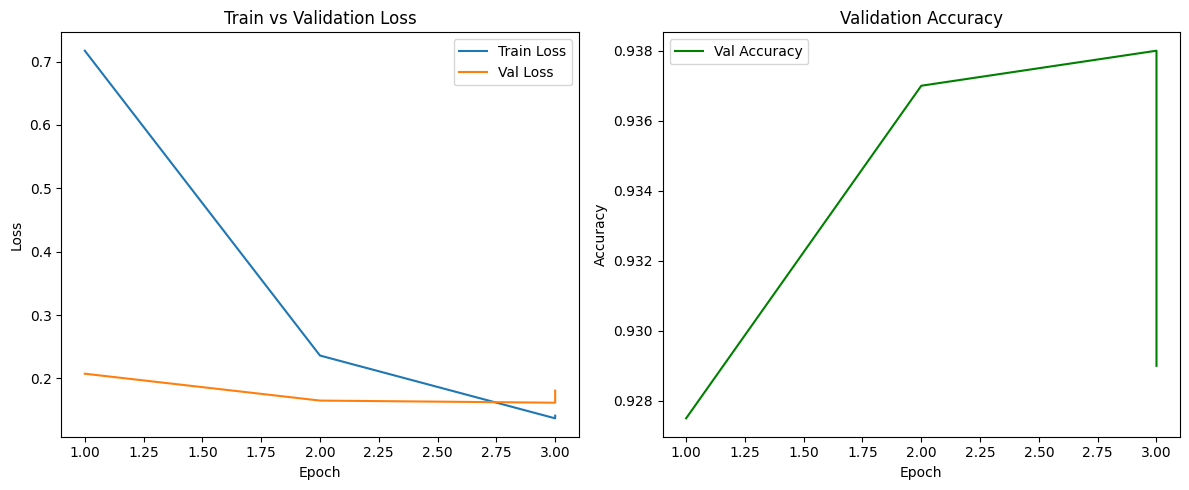

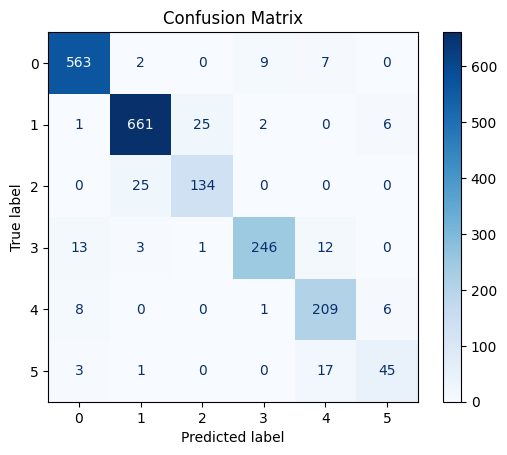

Classification Report:
               precision    recall  f1-score   support

           0     0.9575    0.9690    0.9632       581
           1     0.9552    0.9511    0.9531       695
           2     0.8375    0.8428    0.8401       159
           3     0.9535    0.8945    0.9231       275
           4     0.8531    0.9330    0.8913       224
           5     0.7895    0.6818    0.7317        66

    accuracy                         0.9290      2000
   macro avg     0.8910    0.8787    0.8838      2000
weighted avg     0.9294    0.9290    0.9287      2000



In [ ]:
# train and validation plot
import matplotlib.pyplot as plt

logs = trainer.state.log_history
train_loss = [x['loss'] for x in logs if 'loss' in x and 'epoch' in x]
val_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]
val_acc = [x['eval_accuracy'] for x in logs if 'eval_accuracy' in x]
epochs = [x['epoch'] for x in logs if 'eval_loss' in x]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss[:len(epochs)], label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, label="Val Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predict on test set
preds_output = trainer.predict(hf_datasets['test'])
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Per-class
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

## pre-trained model's interpretability

##Interpretability of BERT Emotion Classifier

**Methods Used:**

**LIME (Local Interpretable Model-agnostic Explanations):**

Provides word-level explanations by highlighting which tokens most influenced the model’s prediction on a given input sentence.
Example: For “I feel extremely anxious and overwhelmed.”, LIME highlights “anxious” and “overwhelmed” as key words driving the emotion prediction.


**Integrated Gradients (IG):**

An intrinsic attribution method applied to BERT embeddings to assign importance scores to each input token relative to the predicted emotion class.
Visualized as a bar plot over tokens, showing contribution strength. Words like “anxious” and “overwhelmed” receive the highest attribution scores.

**Summary:**

Both LIME and IG confirm the model relies heavily on emotionally charged words to make decisions, helping us peek inside the black box and understand why the classifier outputs a particular emotion.

<ipython-input-4-714a10a0c7b5>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=scores, palette='coolwarm')


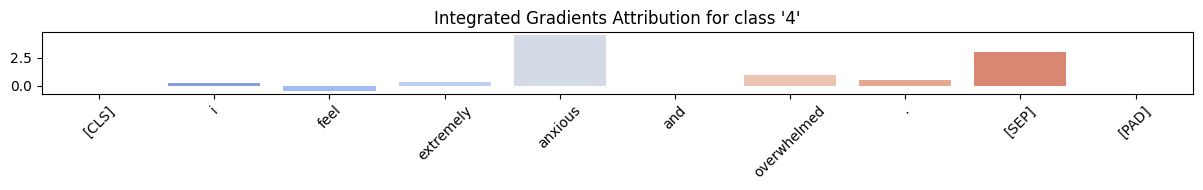

In [ ]:
# Interpretability
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
from captum.attr import IntegratedGradients, visualization
from lime.lime_text import LimeTextExplainer
import numpy as np

# LIME Interpretability
class WrappedHFModel:
    def __init__(self, model, tokenizer):
        self.model = model.eval()
        self.tokenizer = tokenizer

    def predict_proba(self, texts):
        results = []
        for text in texts:
            enc = self.tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
            input_ids = enc['input_ids'].to(model.device)
            attention_mask = enc['attention_mask'].to(model.device)
            with torch.no_grad():
                logits = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            results.append(probs)
        return np.stack(results)

def explain_with_lime_bert(text, model, tokenizer, label_names):
    explainer = LimeTextExplainer(class_names=label_names)
    wrapped = WrappedHFModel(model, tokenizer)
    explanation = explainer.explain_instance(text, wrapped.predict_proba, num_features=10)
    explanation.show_in_notebook()


# Integrated Gradients Interepretability
def explain_with_ig_bert(text, model, tokenizer, label_names, label_idx=None):
    model.eval()
    encoded = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128).to(model.device)
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']

    # Get embeddings for input_ids (this is the baseline input for IG)
    embeddings = model.bert.embeddings.word_embeddings(input_ids)

    def forward_func(inputs_embeds):
        outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        return outputs.logits

    # Get predicted label if none provided
    if label_idx is None:
        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            label_idx = torch.argmax(logits, dim=1).item()

    ig = IntegratedGradients(forward_func)
    baseline = torch.zeros_like(embeddings).to(model.device)

    attributions, delta = ig.attribute(
        inputs=embeddings,
        baselines=baseline,
        target=label_idx,
        return_convergence_delta=True
    )

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    scores = attributions.sum(dim=2).squeeze(0).cpu().detach().numpy()

    # Plot attributions
    plt.figure(figsize=(12, 2))
    sns.barplot(x=tokens, y=scores, palette='coolwarm')
    plt.title(f"Integrated Gradients Attribution for class '{label_names[label_idx]}'")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

text = "I feel extremely anxious and overwhelmed."
explain_with_lime_bert(text, model, tokenizer, label_list)
explain_with_ig_bert(text, model, tokenizer, label_list)

## pre-trained model experiment

In [ ]:
import itertools
import os
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import torch

learning_rates = [2e-5, 3e-5, 5e-5]
weight_decays = [0.0, 0.01, 0.1]
batch_sizes = [16, 32]
num_epochs = [3, 5]

experiment_results = []

for lr, wd, bs, epochs in itertools.product(learning_rates, weight_decays, batch_sizes, num_epochs):
    exp_name = f"lr{lr}_wd{wd}_bs{bs}_ep{epochs}"
    print(f"\n Running experiment: {exp_name}")

    training_args = TrainingArguments(
        output_dir=f"./results/{exp_name}",
        eval_strategy="epoch",
        save_strategy="no",
        learning_rate=lr,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=64,
        num_train_epochs=epochs,
        weight_decay=wd,
        logging_dir=f"./logs/{exp_name}",
        load_best_model_at_end=False,
        report_to=[],
    )

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=num_labels
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=hf_datasets['train'],
        eval_dataset=hf_datasets['validation'],
        tokenizer=tokenizer,
        compute_metrics=lambda p: {"accuracy": np.mean(np.argmax(p.predictions, axis=1) == p.label_ids)},
    )

    trainer.train()

    test_result = trainer.evaluate(hf_datasets['test'])
    y_pred = np.argmax(trainer.predict(hf_datasets['test']).predictions, axis=1)
    y_true = hf_datasets['test']['label']

    experiment_results.append({
        "experiment": exp_name,
        "test_accuracy": test_result["eval_accuracy"],
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred, output_dict=True)
    })

    print(f"{exp_name} | Test Acc: {test_result['eval_accuracy']:.4f}")

## Hyperparameter Tuning on BERT for Emotion Classification

**Goal**: Find the best combination of learning rate, weight decay, batch size, and epochs to maximize accuracy.

**Configs Tested:**

	•	Learning Rates: 2e-5, 3e-5, 5e-5
	•	Weight Decays: 0.0, 0.01, 0.1
	•	Batch Sizes: 16, 32
	•	Epochs: 3, 5

For each config, we recorded:

	•	Test accuracy
	•	Confusion matrix
	•	Classification report
